# Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


# 1.0 Functions & Dataset
## 1.1 Call for library & function

In [1]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers6 import PlotROCCurve

## 1.2 Import & Inspect Dataset

In [2]:
output_path = 'data\\'
path = output_path

df_train = pd.read_csv((os.path.join(path, 'train_impute_v3.csv')))
df_test = pd.read_csv((os.path.join(path, 'test_impute_v3.csv')))

confidence_interval = 95
random_seed = 0

In [3]:
print(len(df_train))
print(len(df_test))
len(df_train) + len(df_test)

273032
68258


341290

In [3]:
df_train['outcome_critical'].value_counts(dropna = False).sort_index()

0    334379
1     23576
Name: outcome_critical, dtype: int64

# 2. Variable Selection 

In [4]:
pd.set_option('display.max_rows', None)
list(df_train)

['intime_ed',
 'outtime_ed',
 'gender',
 'age',
 'outcome_hospitalization',
 'outcome_inhospital_mortality',
 'ed_death',
 'outcome_icu_transfer_12h',
 'outcome_critical',
 'n_ed_30d',
 'n_ed_90d',
 'n_ed_365d',
 'outcome_ed_revisit_3d',
 'n_hosp_30d',
 'n_hosp_90d',
 'n_hosp_365d',
 'n_icu_30d',
 'n_icu_90d',
 'n_icu_365d',
 'ed_los_hours',
 'triage_temperature',
 'triage_heartrate',
 'triage_resprate',
 'triage_o2sat',
 'triage_sbp',
 'triage_dbp',
 'triage_pain',
 'triage_acuity',
 'chiefcom_chest_pain',
 'chiefcom_abdominal_pain',
 'chiefcom_headache',
 'chiefcom_shortness_of_breath',
 'chiefcom_back_pain',
 'chiefcom_cough',
 'chiefcom_nausea_vomiting',
 'chiefcom_fever_chills',
 'chiefcom_syncope',
 'chiefcom_dizziness',
 'cci_MI',
 'cci_CHF',
 'cci_PVD',
 'cci_Stroke',
 'cci_Dementia',
 'cci_Pulmonary',
 'cci_Rheumatic',
 'cci_PUD',
 'cci_Liver1',
 'cci_DM1',
 'cci_DM2',
 'cci_Paralysis',
 'cci_Renal',
 'cci_Cancer1',
 'cci_Liver2',
 'cci_Cancer2',
 'cci_HIV',
 'eci_CHF',
 'eci_

In [5]:
corr_matrix = df_train.corr()
print(corr_matrix)

C:\Users\zhuyi\AppData\Local\Temp\ipykernel_22600\519037272.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


                                gender       age  outcome_hospitalization  \
gender                        1.000000  0.016813                 0.071261   
age                           0.016813  1.000000                 0.331515   
outcome_hospitalization       0.071261  0.331515                 1.000000   
outcome_inhospital_mortality  0.014977  0.097413                 0.108176   
ed_death                           NaN       NaN                      NaN   
outcome_icu_transfer_12h      0.043653  0.141530                 0.270012   
outcome_critical              0.044248  0.152990                 0.278265   
n_ed_30d                      0.063919  0.028796                 0.033391   
n_ed_90d                      0.066363  0.041504                 0.045983   
n_ed_365d                     0.060070  0.045215                 0.039286   
outcome_ed_revisit_3d         0.028473 -0.023064                -0.072956   
n_hosp_30d                    0.062709  0.083920                 0.128089   

In [18]:
# get top 150 pairs of correlated variables
# def get_redundant_pairs(df):
#     '''Get diagonal and lower triangular pairs of correlation matrix'''
#     pairs_to_drop = set()
#     cols = df.columns
#     for i in range(0, df.shape[1]-2):
#         for j in range(0, i+1):
#             pairs_to_drop.add((cols[i], cols[j]))
#     return pairs_to_drop

def get_top_abs_correlations(df, n=150):
    au_corr = df.corr().abs().unstack()
#     labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df_train))

Top Absolute Correlations


C:\Users\zhuyi\AppData\Local\Temp\ipykernel_22600\1689580013.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  au_corr = df.corr().abs().unstack()


gender                        gender                          1.000000
cci_PUD                       cci_PUD                         1.000000
chiefcom_fever_chills         chiefcom_fever_chills           1.000000
chiefcom_syncope              chiefcom_syncope                1.000000
chiefcom_dizziness            chiefcom_dizziness              1.000000
cci_MI                        cci_MI                          1.000000
cci_CHF                       cci_CHF                         1.000000
cci_PVD                       cci_PVD                         1.000000
cci_Stroke                    cci_Stroke                      1.000000
cci_Dementia                  cci_Dementia                    1.000000
cci_Pulmonary                 cci_Pulmonary                   1.000000
                              eci_Pulmonary                   1.000000
cci_Rheumatic                 cci_Rheumatic                   1.000000
cci_Liver1                    cci_Liver1                      1.000000
chiefc

In [21]:
print(get_top_abs_correlations(df_train,300))

C:\Users\zhuyi\AppData\Local\Temp\ipykernel_22600\1689580013.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  au_corr = df.corr().abs().unstack()


gender                        gender                          1.000000
cci_PUD                       cci_PUD                         1.000000
chiefcom_fever_chills         chiefcom_fever_chills           1.000000
chiefcom_syncope              chiefcom_syncope                1.000000
chiefcom_dizziness            chiefcom_dizziness              1.000000
cci_MI                        cci_MI                          1.000000
cci_CHF                       cci_CHF                         1.000000
cci_PVD                       cci_PVD                         1.000000
cci_Stroke                    cci_Stroke                      1.000000
cci_Dementia                  cci_Dementia                    1.000000
cci_Pulmonary                 cci_Pulmonary                   1.000000
                              eci_Pulmonary                   1.000000
cci_Rheumatic                 cci_Rheumatic                   1.000000
cci_Liver1                    cci_Liver1                      1.000000
chiefc

## 2.1 Trim Dataset
### 2.1.1 Full Features
> based on train_drop_v3 & test_drop_v3

In [3]:
variable = list(df_train.columns)
feature_to_remove = {'intime_ed','outtime_ed','outcome_hospitalization','outcome_inhospital_mortality','ed_death', 
                   'outcome_icu_transfer_12h','outcome_critical','outcome_ed_revisit_3d',
                    'eci_Pulmonary','eci_HIV','eci_Tumor2','eci_CHF','eci_Renal','eci_PVD',
                     'eci_Liver','score_NEWS','eci_DM1','eci_DM2','triage_dbp','eci_PUD','eci_HTN1',
                     'eci_Paralysis','eci_Tumor1','eci_Rheumatic','score_REMS',
                     'age_group_Young Adults','age_group_Middle-Aged Adults','age_group_Older Adults','age_group_Elderly'
                    } # y-variables and highly correlated x-variables
variable = [item for item in variable if item not in feature_to_remove]

outcome = "outcome_critical"

### 2.1.2 Features for First Prediction
> based on ED triage. Hence, assumming without information about the number of unique medication given during ED, length of stay in ED as well as insurance information.

In [4]:
variable2 = ['gender','age',
             'n_ed_30d','n_ed_90d','n_ed_365d','n_hosp_30d','n_hosp_90d','n_hosp_365d','n_icu_30d','n_icu_90d',
             'n_icu_365d',
             'triage_temperature','triage_heartrate','triage_resprate','triage_o2sat','triage_sbp',
             'triage_pain','triage_acuity',
             'chiefcom_chest_pain','chiefcom_abdominal_pain','chiefcom_headache','chiefcom_shortness_of_breath',
             'chiefcom_back_pain','chiefcom_cough','chiefcom_nausea_vomiting','chiefcom_fever_chills','chiefcom_syncope',
             'chiefcom_dizziness',
             'cci_MI','cci_CHF','cci_PVD','cci_Stroke','cci_Dementia','cci_Pulmonary','cci_Rheumatic','cci_PUD',
             'cci_Liver1','cci_DM1','cci_DM2','cci_Paralysis','cci_Renal','cci_Cancer1','cci_Liver2','cci_Cancer2',
             'cci_HIV',    
             'eci_Arrhythmia','eci_Valvular','eci_PHTN','eci_HTN2','eci_NeuroOther','eci_Hypothyroid',
             'eci_Lymphoma','eci_Coagulopathy','eci_Obesity','eci_WeightLoss','eci_FluidsLytes',
             'eci_BloodLoss','eci_Anemia','eci_Alcohol','eci_Drugs','eci_Psychoses','eci_Depression',
             'n_medrecon','triage_MAP']

## 2.2 Set Up Machine Learning Pipeline 
### 2.2.1 Full Features

In [13]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [25]:
X_train.dtypes.to_frame().T

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,...,n_med,n_medrecon,insurance_Medicaid,insurance_Medicare,insurance_Other,triage_MAP,score_CCI,score_CART,score_NEWS2,score_MEWS
0,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,...,float64,float64,int64,int64,int64,float64,int64,int64,int64,int64


In [26]:
total_count = y_train.count()
print("Total number of values in y_train:", total_count)

Total number of values in y_train: 357955


In [6]:
# impute median for triage_acuity for X_train
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train[['triage_acuity']] = imputer.fit_transform(X_train[['triage_acuity']])
X_train[['triage_acuity']] = imputer.transform(X_train[['triage_acuity']])

In [7]:
# impute median for triage_acuity for X_test
X_test[['triage_acuity']] = imputer.fit_transform(X_test[['triage_acuity']])
X_test[['triage_acuity']] = imputer.transform(X_test[['triage_acuity']])

In [8]:
# dummy encode triage_acuity
X_train = pd.get_dummies(X_train, columns=['triage_acuity'])
X_test = pd.get_dummies(X_test, columns=['triage_acuity'])

In [30]:
X_train.head()

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,...,triage_MAP,score_CCI,score_CART,score_NEWS2,score_MEWS,triage_acuity_1.0,triage_acuity_2.0,triage_acuity_3.0,triage_acuity_4.0,triage_acuity_5.0
0,0,48.0,0,1,1,0,1,1,0,0,...,109.000000,2,0,0,1,0,0,1,0,0
1,1,70.0,0,0,0,0,0,0,0,0,...,105.000000,3,9,0,1,0,1,0,0,0
2,1,36.0,0,0,0,0,0,0,0,0,...,78.333333,0,0,1,0,0,0,1,0,0
3,0,22.0,0,0,0,1,1,1,0,0,...,87.666667,0,0,1,1,0,0,1,0,0
4,0,68.0,3,4,4,2,3,3,0,0,...,72.666667,15,4,1,1,0,1,0,0,0


### 2.2.2 First Prediction

In [5]:
X_train2 = df_train[variable2].copy()
X_test2 = df_test[variable2].copy()

In [8]:
# impute median for triage_acuity X_train2
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train2[['triage_acuity']] = imputer.fit_transform(X_train2[['triage_acuity']])
X_train2[['triage_acuity']] = imputer.transform(X_train2[['triage_acuity']])

In [9]:
# impute median for triage_acuity for X_test2
X_test2[['triage_acuity']] = imputer.fit_transform(X_test2[['triage_acuity']])
X_test2[['triage_acuity']] = imputer.transform(X_test2[['triage_acuity']])

In [10]:
# dummy encode triage_acuity
X_train2 = pd.get_dummies(X_train2, columns=['triage_acuity'])
X_test2 = pd.get_dummies(X_test2, columns=['triage_acuity'])

In [19]:
pd.set_option('display.max_columns', 200)
X_train2.dtypes.to_frame().T

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,n_medrecon,triage_MAP,triage_acuity_1.0,triage_acuity_2.0,triage_acuity_3.0,triage_acuity_4.0,triage_acuity_5.0
0,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,uint8,uint8,uint8,uint8,uint8


## 2.3 Class Ratio

In [14]:
print('class ratio')
ratio = y_train.sum()/(len(y_train)-y_train.sum())
print('positive : negative =', ratio, ': 1')

class ratio
positive : negative = 0.07050682010532958 : 1


# 3.  Modeling script

In [14]:
# Containers for all results
result_list = []

## 3.1 Logistic Regression Model
### 3.1.1 Full Features

Logistic Regression:


C:\Users\zhuyi\anaconda3\envs\aha\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 6.778563022613525 seconds
AUC: 0.886238002712114
AUPRC: 0.41354703117855174
Sensitivity: 0.8222972972972973
Specificity: 0.791693091936005
Score thresold: 0.48088120589922423
2.5 97.5


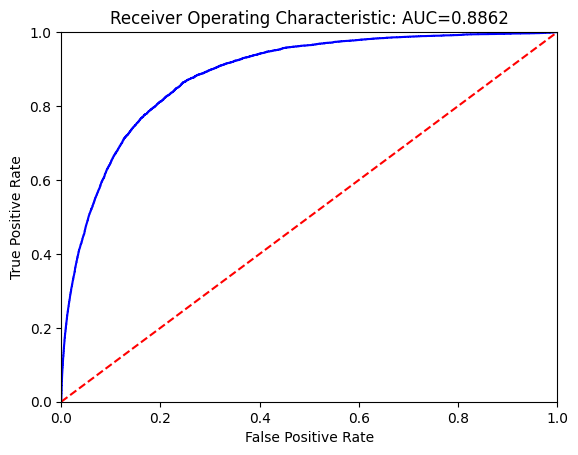

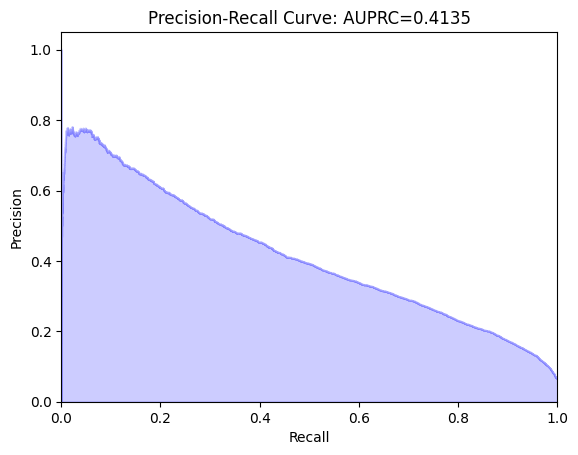

In [37]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(class_weight='balanced', random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.1.2 LR - First Prediction

Logistic Regression:


C:\Users\zhuyi\anaconda3\envs\aha\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.864940404891968 seconds
AUC: 0.8291517642162021
AUPRC: 0.3104728356091355
Sensitivity: 0.7364864864864865
Specificity: 0.7659778147399156
Score thresold: 0.4950418770034065
2.5 97.5


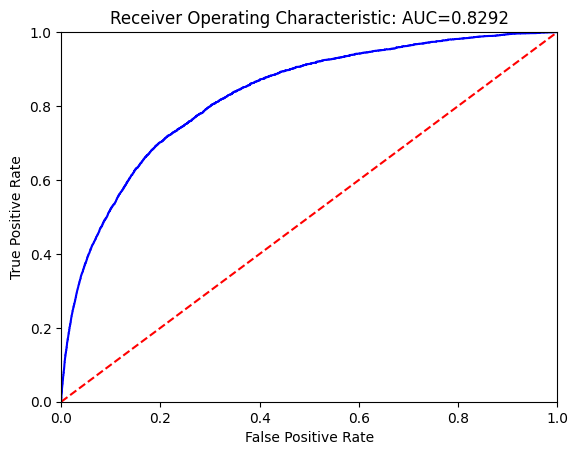

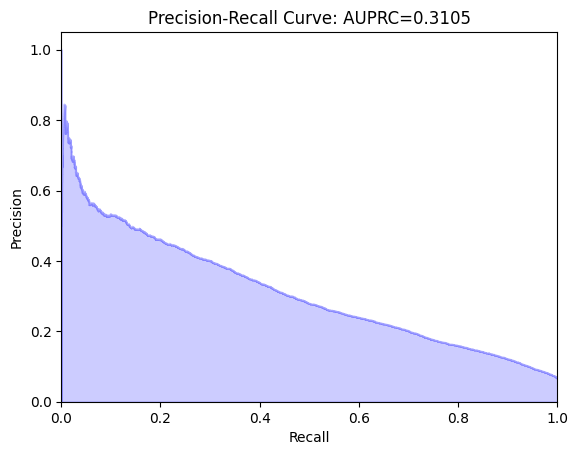

In [38]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression

# create logistic regression model. For reproducibility, set 'random_seed' which is 0
logreg = LogisticRegression(class_weight='balanced', random_state = random_seed)

# record the current time before training the model to cacluate the total training time.
start = time.time()

# logistic regression model to use the training data.
logreg.fit(X_train2, y_train)

# calculate the total time it took to train this model.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# use the trained model to predict the probabilities for the test data ('X_test')
probs = logreg.predict_proba(X_test2)

# generate a ROC curve for the model and computes performance metrics like AUC (area under the curve).
result = PlotROCCurve(probs[:,1], y_test, ci = confidence_interval, random_seed = random_seed)
results = ["LRv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.2 Random Forest Model
### 3.2.1 Full Features

RandomForest:
Training time: 71.01652359962463 seconds
AUC: 0.9427515947737636
AUPRC: 0.6154535264752139
Sensitivity: 0.885472972972973
Specificity: 0.8503033421484043
Score thresold: 0.09
2.5 97.5


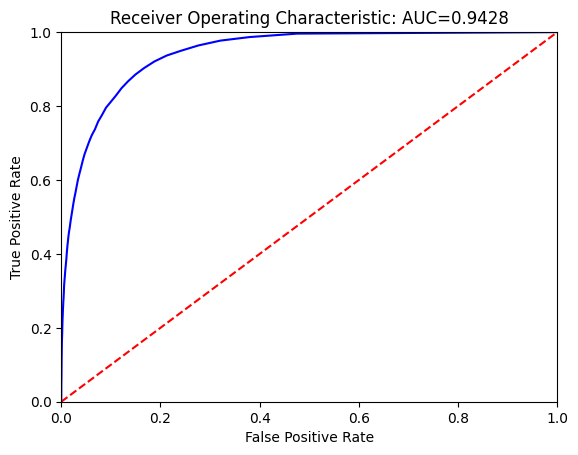

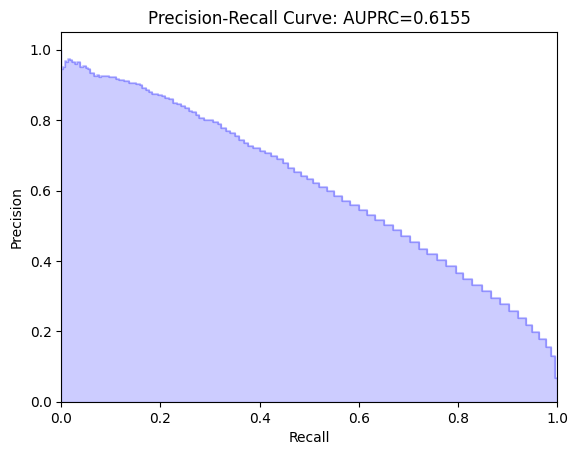

[4.05287878e-03 3.43964804e-02 2.50999055e-03 4.21313142e-03
 7.91411065e-03 2.22536375e-03 3.68161002e-03 6.22164905e-03
 9.62515001e-04 2.14046249e-03 3.81214497e-03 1.99219291e-01
 2.24152224e-02 3.14499907e-02 1.37084138e-02 2.27731734e-02
 3.30353427e-02 3.32566822e-02 4.94006393e-03 2.78166829e-03
 1.90262852e-03 3.15101186e-04 9.41724073e-04 8.91480947e-04
 8.25580384e-04 1.43981475e-03 1.10226513e-03 1.24583690e-03
 1.40949209e-03 1.76789112e-03 1.39537762e-03 1.39154485e-03
 7.22106671e-04 1.94079509e-03 8.57531473e-04 6.70142555e-04
 1.39322860e-03 2.02464510e-03 1.40255926e-03 6.66762238e-04
 1.95197370e-03 1.65341629e-03 8.18521623e-04 1.14618518e-03
 3.29691123e-04 2.07621774e-03 1.40878773e-03 1.24191424e-03
 2.77015067e-03 1.58490621e-03 1.62933188e-03 6.24736003e-04
 1.68579820e-03 1.61321124e-03 1.26385406e-03 2.68576876e-03
 7.14685488e-04 1.22948028e-03 1.56398187e-03 1.41935048e-03
 1.00852878e-03 2.48106355e-03 1.84708054e-02 3.87848018e-02
 4.42214299e-02 1.237950

In [39]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(class_weight='balanced', random_state = random_seed)
start = time.time()
rf.fit(X_train, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF1 = rf.feature_importances_
print(importancesRF1)
results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.2.2 RF - First Prediction

RandomForest:
Training time: 65.2408492565155 seconds
AUC: 0.8792488002712116
AUPRC: 0.39646448216558605
Sensitivity: 0.8074324324324325
Specificity: 0.8046524428915028
Score thresold: 0.08
2.5 97.5


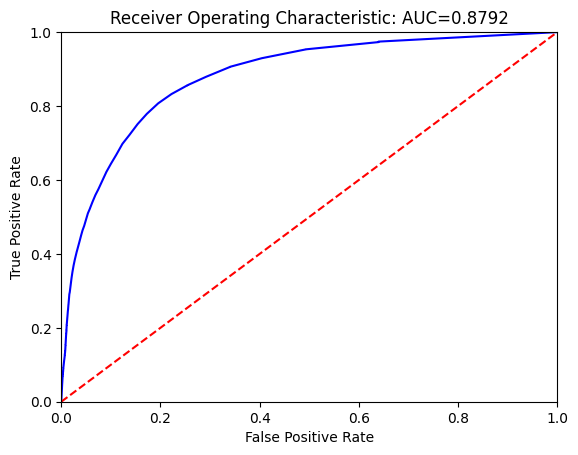

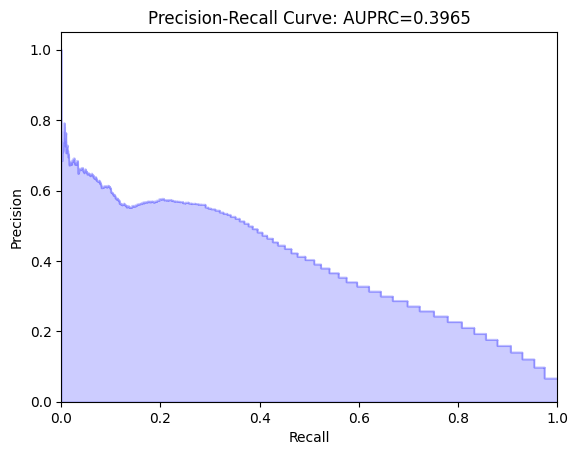

[0.01054132 0.09111833 0.00527366 0.0084197  0.01689503 0.00444121
 0.00749786 0.01290701 0.00142645 0.00441825 0.00906154 0.05663012
 0.08210292 0.04402972 0.05390399 0.08003319 0.05770352 0.00827566
 0.0057402  0.00350022 0.00068143 0.00248936 0.00185962 0.00217754
 0.0030169  0.00304019 0.00324819 0.00315361 0.00556892 0.00310218
 0.00312307 0.00153352 0.0045831  0.0016855  0.00147792 0.00308607
 0.00507864 0.00329546 0.00130421 0.00475201 0.00398474 0.00182668
 0.0027632  0.00067047 0.00557875 0.00303851 0.00272568 0.0061285
 0.00357232 0.00361185 0.00106363 0.00450012 0.00361217 0.002722
 0.00758361 0.00135704 0.00272675 0.00329875 0.00300336 0.00202699
 0.00503773 0.04504165 0.08721228 0.05159858 0.02979551 0.07374532
 0.01930064 0.00029582]


In [40]:
print("RandomForest:")

rf= RandomForestClassifier(class_weight='balanced', random_state = random_seed)
start = time.time()
rf.fit(X_train2, 
       y_train)
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = rf.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesRF2 = rf.feature_importances_
print(importancesRF2)
results = ["RFv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.3 Gradient Boosting Model
### 3.3.1  Full Features

In [15]:
# calculate class weights
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y_train),
                                     y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 0.5352534100526648, 1: 7.591512555140821}

GradientBoosting:
Training time: 113.29279708862305 seconds
AUC: 0.9454700576364635
AUPRC: 0.632886860214964
Sensitivity: 0.8782094594594595
Specificity: 0.8545513288420348
Score thresold: 0.08035201420399152
2.5 97.5


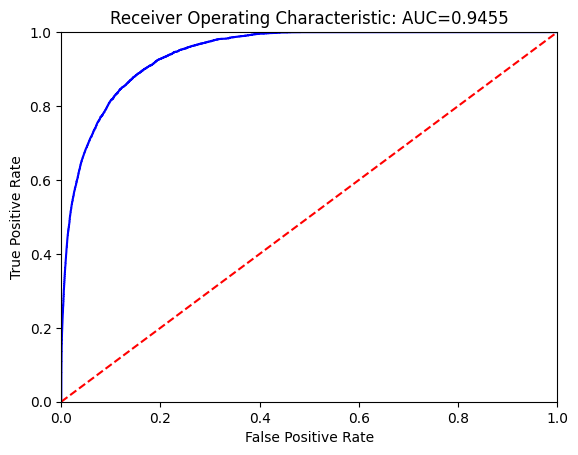

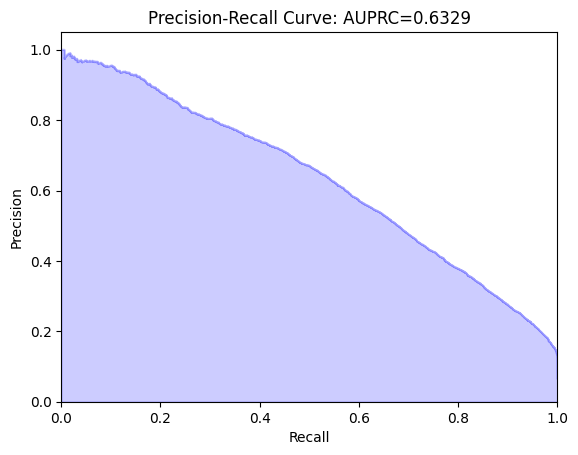

[3.24906671e-04 9.56903676e-03 0.00000000e+00 4.29353408e-05
 3.75898250e-03 0.00000000e+00 0.00000000e+00 7.55321978e-05
 0.00000000e+00 2.10612914e-03 4.62981200e-03 3.17768986e-01
 7.32258508e-03 7.99589079e-03 4.10805657e-04 3.76708477e-03
 2.12718183e-02 4.77611200e-02 3.10604201e-03 0.00000000e+00
 2.29949126e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.98248781e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.21196368e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.45852567e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.18915503e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.16907010e-05 6.61332542e-05 0.00000000e+00 0.00000000e+00
 1.71467418e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.17134318e-04 4.31182777e-03 6.23459999e-02
 1.25493772e-01 2.776126

In [42]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train, 
       y_train, 
       class_weights.get('1'))
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesGB1 = gb.feature_importances_
print(importancesGB1)
results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.3.2 GB - First Prediction

GradientBoosting:
Training time: 73.49917602539062 seconds
AUC: 0.88682870046212
AUPRC: 0.4378342435789693
Sensitivity: 0.8087837837837838
Specificity: 0.8049276645646113
Score thresold: 0.06956934954968859
2.5 97.5


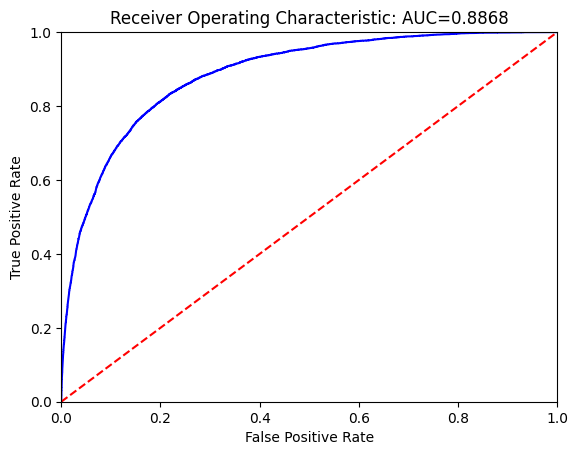

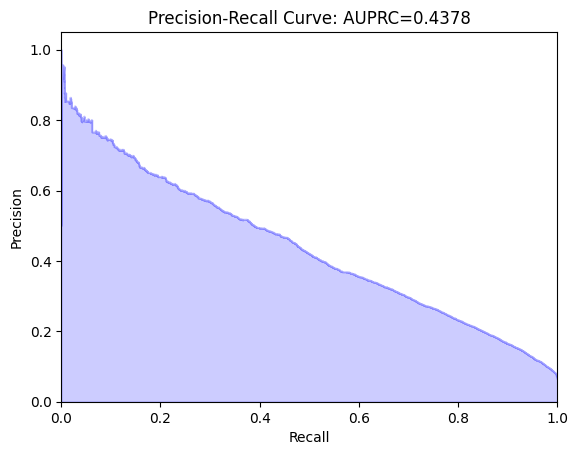

[1.39646560e-03 6.62044186e-02 1.22648508e-04 4.55816971e-04
 1.22341126e-02 0.00000000e+00 1.70172940e-04 1.43496438e-04
 4.93466317e-04 5.82139126e-03 2.42416932e-02 1.75477477e-02
 1.08425208e-01 4.56227918e-02 3.34519339e-02 5.25864297e-02
 6.13415884e-02 8.03067708e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.33815846e-04 0.00000000e+00
 8.30409215e-05 1.42544281e-03 8.67001029e-04 0.00000000e+00
 1.44691743e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.32760129e-04 0.00000000e+00 1.16914577e-04 2.83583381e-05
 1.39936059e-03 2.77688493e-04 0.00000000e+00 1.52403132e-04
 0.00000000e+00 8.54262698e-04 1.30282848e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.81307592e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.71342479e-03
 1.59950306e-04 6.94982176e-05 1.48448113e-03 0.00000000e+00
 0.00000000e+00 7.79752598e-05 0.00000000e+00 0.00000000e+00
 2.03572534e-04 4.11536409e-02 8.42881253e-02 3.31743728e-01
 8.13616842e-02 9.182233

In [43]:
print("GradientBoosting:")

gb = GradientBoostingClassifier(random_state = random_seed)
start = time.time()
gb.fit(X_train2, 
       y_train, 
       class_weights.get('1'))
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

probs = gb.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1], 
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)

importancesGB2 = gb.feature_importances_
print(importancesGB2)
results = ["GBv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.5 XGBoost
### 3.5.1 Full Features

In [15]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', n_jobs=-1, random_state=random_seed)

Training time: 13.704453229904175 seconds
AUC: 0.9528434526348675
AUPRC: 0.6725182939944364
Sensitivity: 0.8846283783783784
Specificity: 0.8679653938661466
Score thresold: 0.0059434855
2.5 97.5


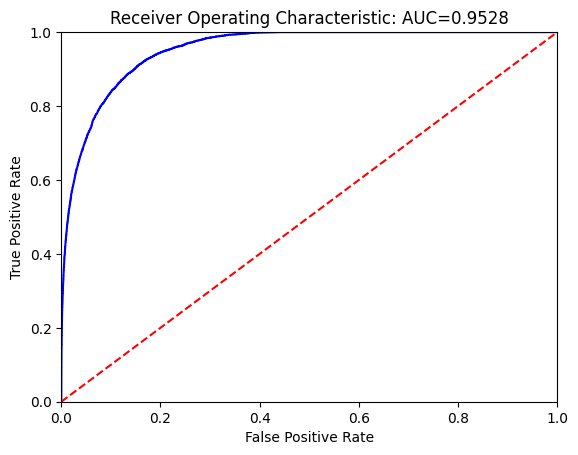

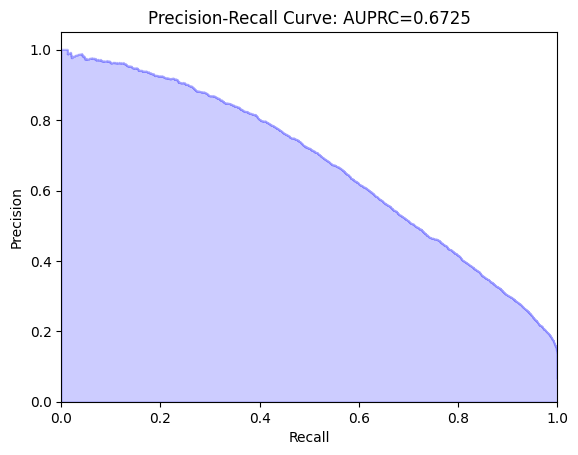

In [31]:
start = time.time()
xgb_clf.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = xgb_clf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["XGB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.5.2 XGB - First Prediction

In [20]:
X_train2.head()

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,n_medrecon,triage_MAP,triage_acuity_1.0,triage_acuity_2.0,triage_acuity_3.0,triage_acuity_4.0,triage_acuity_5.0
0,0,48.0,0,1,1,0,1,1,0,0,0,36.222222,79.0,18.0,100.0,143.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,17.0,109.000000,0,0,1,0,0
1,1,70.0,0,0,0,0,0,0,0,0,0,36.611111,61.0,16.0,98.0,159.0,0.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,2.0,105.000000,0,1,0,0,0
2,1,36.0,0,0,0,0,0,0,0,0,0,36.222222,58.0,14.0,100.0,103.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,78.333333,0,0,1,0,0
3,0,22.0,0,0,0,1,1,1,0,0,0,36.388889,95.0,18.0,98.0,121.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0,87.666667,0,0,1,0,0
4,0,68.0,3,4,4,2,3,3,0,0,0,36.388889,71.0,18.0,98.0,108.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1,23.0,72.666667,0,1,0,0,0


In [22]:
X_test2.head()

,gender,age,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_pain,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,n_medrecon,triage_MAP,triage_acuity_1.0,triage_acuity_2.0,triage_acuity_3.0,triage_acuity_4.0,triage_acuity_5.0
0,1,24.0,0,0,0,0,0,0,0,0,0,36.444444,81.0,18.0,99.0,120.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,87.333333,0,0,1,0,0
1,0,57.0,0,0,0,0,0,0,0,0,0,36.166667,119.0,16.0,99.0,100.0,7.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,70.000000,0,0,1,0,0
2,1,81.0,0,0,0,0,0,0,0,0,0,38.388889,87.0,20.0,95.0,133.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,86.333333,0,0,1,0,0
3,1,22.0,0,0,0,0,0,0,0,0,0,36.222222,92.0,18.0,98.0,132.0,6.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,96.666667,0,0,1,0,0
4,1,19.0,0,0,0,0,0,0,0,0,0,36.333333,81.0,18.0,100.0,159.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,118.333333,0,0,1,0,0


Training time: 12.530920028686523 seconds
AUC: 0.8943582649618231
AUPRC: 0.45132960200009725
Sensitivity: 0.8125
Specificity: 0.8160681592456533
Score thresold: 0.0053910557
2.5 97.5


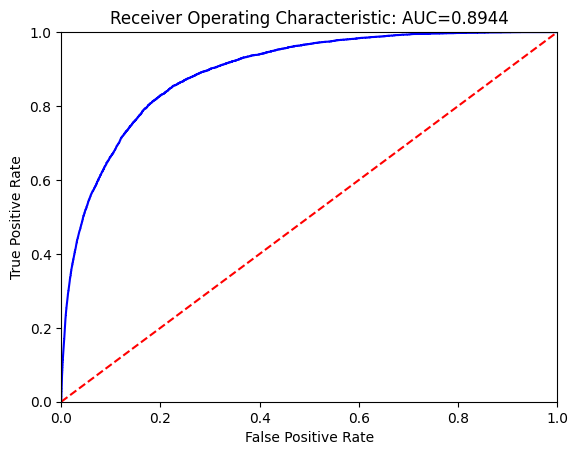

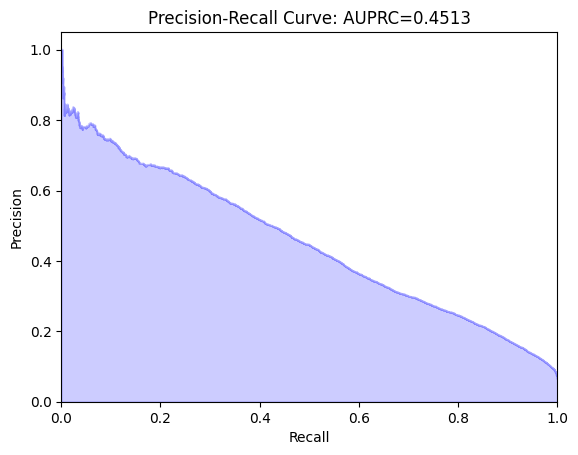

NameError: name 'result_list' is not defined

In [16]:
start = time.time()
xgb_clf.fit(X_train2, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = xgb_clf.predict_proba(X_test2)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["XGBv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.4 Keras Model - Multi-Layer Perceptron (MLP)
### 3.4.1 Full Features

In [17]:
# Defines a custom class MLP that inherits from tf.keras.Model,which means it's a Keras model.
# This class will represent our Multi-Layer Perceptron (MLP) model.

class MLP(tf.keras.Model):
# define the layers of our MLP model.
    def __init__(self):
        super(MLP, self).__init__()      
# The Dense layers represent fully connected layers in the neural network. 
# The first layer has 128 neurons with a ReLU activation function, 
# the second layer has 64 neurons with a ReLU activation function, 
# and the final output layer has one neuron with a sigmoid activation function 
# for binary classification.
        self.dense_1 = Dense(128, activation = 'relu')
        self.dense_2 = Dense(64, activation = 'relu')
        self.classifier = Dense(1, activation = 'sigmoid')

        
# The call method is used to define the forward pass of the model. 
# It specifies how the input data x will pass through the layers defined in the __init__ method. 
# In this case, the input data first goes through dense_1, then dense_2, and finally 
# through the classifier layer. The output of the classifier layer is the model's prediction.
    def call(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        return self.classifier(x)

In [49]:
# skip this cell if not retraining
# an instance of the MLP class is created, which represents our MLP model.
mlp = MLP()

# compile it with various settings. 
# The loss function used for training is binary cross-entropy since it's a binary 
# classification problem.
# The optimizer used is Adam with a learning rate of 0.001. 
# The metrics parameter includes several evaluation metrics such as accuracy, 
# area under the ROC curve (AUC), 
# area under the precision-recall curve (AUPRC), 
# true positives, true negatives, precision, and recall.
mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
# the model is trained using the fit method on the training data (X_train and y_train). 
# The batch_size determines the number of samples used in each gradient update during 
# training. The epochs parameter specifies the number of times the entire training dataset 
# is passed through the model during training. 
mlp.fit(X_train.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

# The training time (runtime) is recorded.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# After training, the model is saved to a file named 'critical_triage_mlp' for future use.
mlp.save('critical_triage_mlp')

Epoch 1/20
1790/1790 [==============================] - 4s 2ms/step - loss: 0.1844 - accuracy: 0.9387 - auc: 0.8645 - auprc: 0.4053 - true_positives: 6074.0000 - true_negatives: 329926.0000 - precision: 0.5770 - recall: 0.2576
Epoch 2/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1482 - accuracy: 0.9437 - auc: 0.9203 - auprc: 0.5185 - true_positives: 7542.0000 - true_negatives: 330253.0000 - precision: 0.6464 - recall: 0.3199
Epoch 3/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1393 - accuracy: 0.9459 - auc: 0.9313 - auprc: 0.5562 - true_positives: 8110.0000 - true_negatives: 330464.0000 - precision: 0.6744 - recall: 0.3440
Epoch 4/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1359 - accuracy: 0.9470 - auc: 0.9351 - auprc: 0.5732 - true_positives: 8361.0000 - true_negatives: 330620.0000 - precision: 0.6899 - recall: 0.3546
Epoch 5/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1334 - accurac

MLP:
Training time: 189.77136278152466 seconds
2797/2797 [==============================] - 2s 773us/step
AUC: 0.9468260155550375
AUPRC: 0.6363674645213895
Sensitivity: 0.8798986486486486
Specificity: 0.8526128109705752
Score thresold: 0.05924206
2.5 97.5


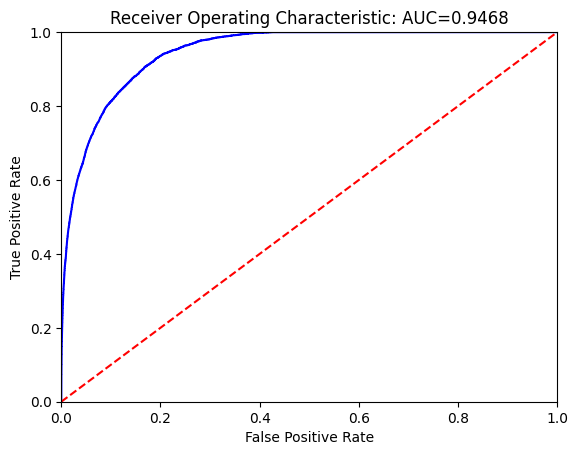

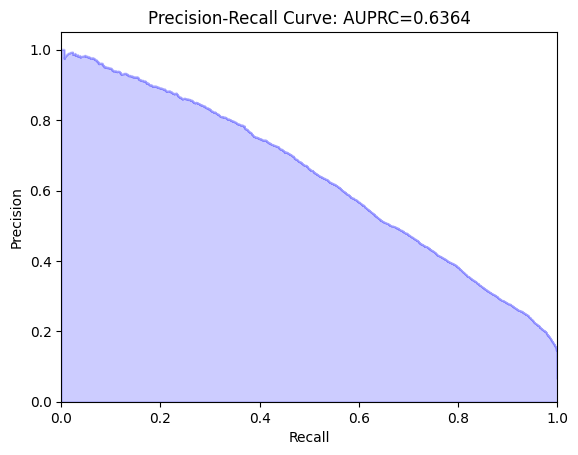

In [50]:
print("MLP:")
print('Training time:', runtime, 'seconds')
# This line loads the previously saved Keras model named 'critical_triage_mlp' from a file 
# and assigns it to the variable mlp. 
mlp = load_model('critical_triage_mlp')

# This line uses the loaded model (mlp) to make predictions on the test data X_test. 
# The predictions are probabilities generated by the sigmoid activation function in the 
# output layer.
probs = mlp.predict(X_test.astype(np.float32))

# This line calls the function PlotROCCurve to generate a Receiver Operating Characteristic (ROC) 
# curve for the model's predictions (probs) and the ground truth labels (y_test). 
# The ci, confidence_interval, and random_seed are arguments passed to the function.
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.4.2 MLP - First Prediction

In [56]:
mlp = MLP()

mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train2.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20)

runtime = time.time() - start
print('Training time:', runtime, 'seconds')

mlp.save('critical_triage_mlp')

Epoch 1/20
1790/1790 [==============================] - 4s 2ms/step - loss: 0.2075 - accuracy: 0.9341 - auc: 0.8020 - auprc: 0.2737 - true_positives: 2635.0000 - true_negatives: 331737.0000 - precision: 0.4993 - recall: 0.1118
Epoch 2/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1881 - accuracy: 0.9362 - auc: 0.8402 - auprc: 0.3365 - true_positives: 3403.0000 - true_negatives: 331722.0000 - precision: 0.5616 - recall: 0.1443
Epoch 3/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1841 - accuracy: 0.9370 - auc: 0.8506 - auprc: 0.3512 - true_positives: 3608.0000 - true_negatives: 331795.0000 - precision: 0.5827 - recall: 0.1530
Epoch 4/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1794 - accuracy: 0.9373 - auc: 0.8617 - auprc: 0.3709 - true_positives: 3634.0000 - true_negatives: 331869.0000 - precision: 0.5915 - recall: 0.1541
Epoch 5/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.1759 - accurac

MLP:
Training time: 192.72611212730408 seconds
2797/2797 [==============================] - 2s 733us/step
AUC: 0.8870296349221698
AUPRC: 0.42031065712427246
Sensitivity: 0.8091216216216216
Specificity: 0.8046165444124017
Score thresold: 0.07913284
2.5 97.5


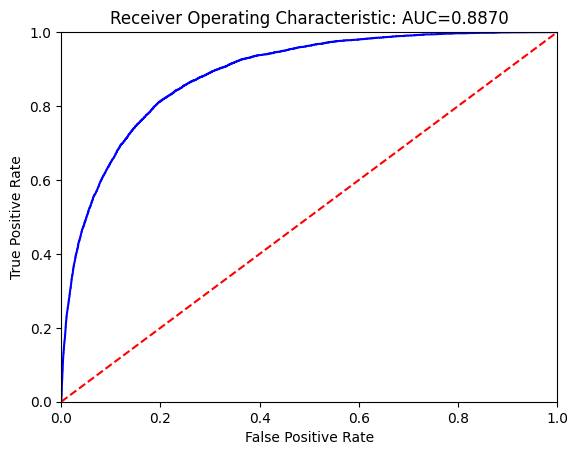

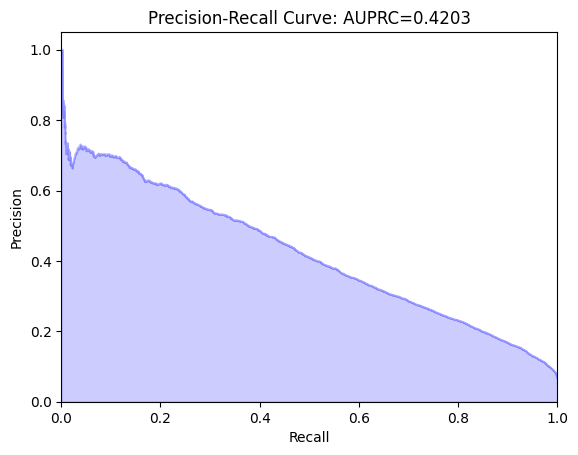

AttributeError: 'MLP' object has no attribute 'feature_importances_'

In [57]:
print("MLP:")
print('Training time:', runtime, 'seconds')
mlp = load_model('critical_triage_mlp')
probs = mlp.predict(X_test2.astype(np.float32))
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
importancesMLP2 = mlp.feature_importances_
# print(importancesMLP2)
# results = ["MLPv2"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)

In [59]:
results = ["MLPv2"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.4.1.1 MLP - Full features, balanced class weights

In [61]:
# skip this cell if not retraining
# an instance of the MLP class is created, which represents our MLP model.
mlp = MLP()

# compile it with various settings. 
# The loss function used for training is binary cross-entropy since it's a binary 
# classification problem.
# The optimizer used is Adam with a learning rate of 0.001. 
# The metrics parameter includes several evaluation metrics such as accuracy, 
# area under the ROC curve (AUC), 
# area under the precision-recall curve (AUPRC), 
# true positives, true negatives, precision, and recall.
mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
# the model is trained using the fit method on the training data (X_train and y_train). 
# The batch_size determines the number of samples used in each gradient update during 
# training. The epochs parameter specifies the number of times the entire training dataset 
# is passed through the model during training. 
mlp.fit(X_train.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20,
        class_weight=class_weights)

# The training time (runtime) is recorded.
runtime = time.time() - start
print('Training time:', runtime, 'seconds')

# After training, the model is saved to a file named 'critical_triage_mlp' for future use.
mlp.save('critical_triage_mlp')

Epoch 1/20
1790/1790 [==============================] - 3s 1ms/step - loss: 0.5006 - accuracy: 0.7847 - auc: 0.8670 - auprc: 0.3351 - true_positives: 18630.0000 - true_negatives: 262261.0000 - precision: 0.2053 - recall: 0.7902
Epoch 2/20
1790/1790 [==============================] - 3s 1ms/step - loss: 0.3522 - accuracy: 0.8190 - auc: 0.9202 - auprc: 0.4952 - true_positives: 20315.0000 - true_negatives: 272839.0000 - precision: 0.2482 - recall: 0.8617
Epoch 3/20
1790/1790 [==============================] - 3s 1ms/step - loss: 0.3222 - accuracy: 0.8230 - auc: 0.9309 - auprc: 0.5290 - true_positives: 20884.0000 - true_negatives: 273710.0000 - precision: 0.2561 - recall: 0.8858
Epoch 4/20
1790/1790 [==============================] - 3s 1ms/step - loss: 0.3094 - accuracy: 0.8255 - auc: 0.9356 - auprc: 0.5567 - true_positives: 21115.0000 - true_negatives: 274373.0000 - precision: 0.2603 - recall: 0.8956
Epoch 5/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.3035 - acc

MLP:
Training time: 188.83098649978638 seconds
2797/2797 [==============================] - 2s 727us/step
AUC: 0.9459180761131842
AUPRC: 0.6292589618976894
Sensitivity: 0.8827702702702702
Specificity: 0.8540128516555182
Score thresold: 0.48862287
2.5 97.5


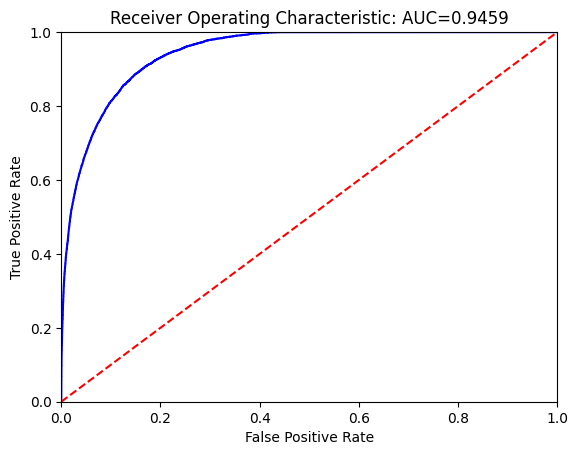

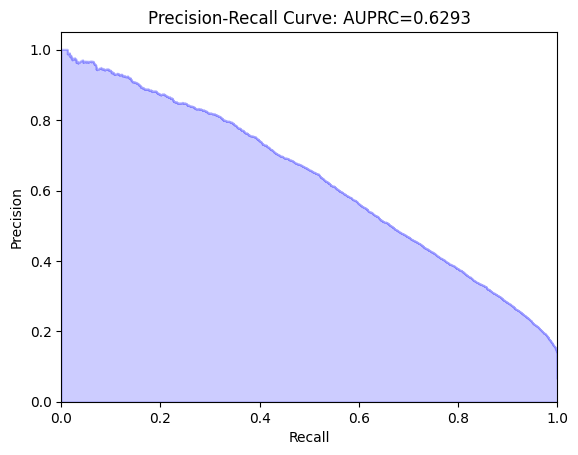

In [62]:
print("MLP:")
print('Training time:', runtime, 'seconds')
# This line loads the previously saved Keras model named 'critical_triage_mlp' from a file 
# and assigns it to the variable mlp. 
mlp = load_model('critical_triage_mlp')

# This line uses the loaded model (mlp) to make predictions on the test data X_test. 
# The predictions are probabilities generated by the sigmoid activation function in the 
# output layer.
probs = mlp.predict(X_test.astype(np.float32))

# This line calls the function PlotROCCurve to generate a Receiver Operating Characteristic (ROC) 
# curve for the model's predictions (probs) and the ground truth labels (y_test). 
# The ci, confidence_interval, and random_seed are arguments passed to the function.
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
results = ["MLP_bal"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 3.4.2.1 MLP - First Prediction, balanced class weights

In [18]:
mlp = MLP()

mlp.compile(loss = 'binary_crossentropy', 
            optimizer = optimizers.Adam(learning_rate = 0.001), 
            metrics = ['accuracy', 'AUC', {'auprc': metrics.AUC(name = 'auprc', curve = 'PR')},
                       'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
start = time.time()
mlp.fit(X_train2.astype(np.float32), 
        y_train, 
        batch_size = 200, 
        epochs = 20,
        class_weight=class_weights)

runtime = time.time() - start
print('Training time:', runtime, 'seconds')

mlp.save('critical_triage_mlp')

Epoch 1/20
1790/1790 [==============================] - 4s 2ms/step - loss: 0.5635 - accuracy: 0.7321 - auc: 0.7995 - auprc: 0.2334 - true_positives: 17036.0000 - true_negatives: 245012.0000 - precision: 0.1601 - recall: 0.7226
Epoch 2/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.4973 - accuracy: 0.7599 - auc: 0.8393 - auprc: 0.3134 - true_positives: 17862.0000 - true_negatives: 254152.0000 - precision: 0.1821 - recall: 0.7576
Epoch 3/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.4754 - accuracy: 0.7688 - auc: 0.8535 - auprc: 0.3395 - true_positives: 18314.0000 - true_negatives: 256877.0000 - precision: 0.1911 - recall: 0.7768
Epoch 4/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.4614 - accuracy: 0.7722 - auc: 0.8626 - auprc: 0.3560 - true_positives: 18676.0000 - true_negatives: 257719.0000 - precision: 0.1959 - recall: 0.7922
Epoch 5/20
1790/1790 [==============================] - 3s 2ms/step - loss: 0.4518 - acc

MLP:
Training time: 58.89276146888733 seconds
2797/2797 [==============================] - 2s 755us/step
AUC: 0.888940318333806
AUPRC: 0.43112152835874845
Sensitivity: 0.8043918918918919
Specificity: 0.8102406394715744
Score thresold: 0.53461623
2.5 97.5


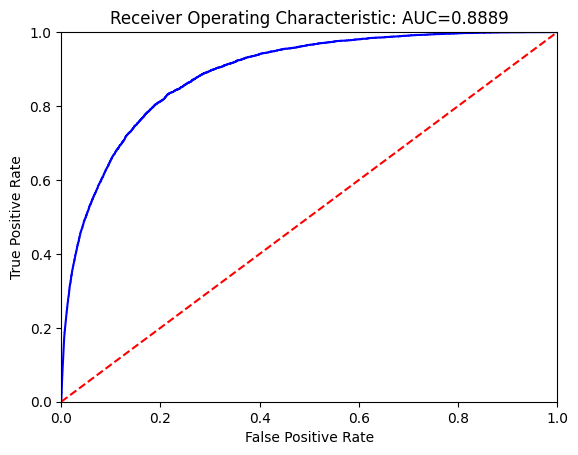

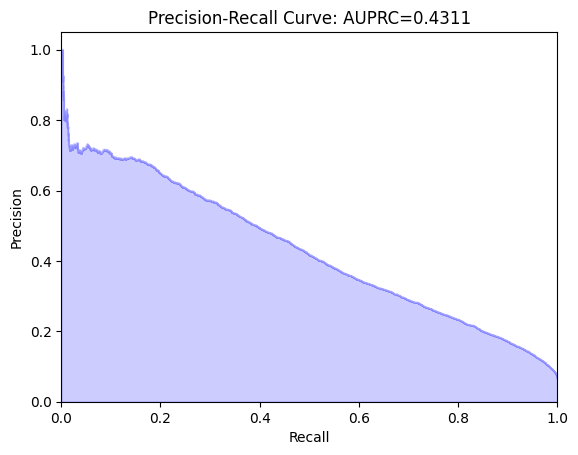

In [19]:
print("MLP:")
print('Training time:', runtime, 'seconds')
# This line loads the previously saved Keras model named 'critical_triage_mlp' from a file 
# and assigns it to the variable mlp. 
mlp = load_model('critical_triage_mlp')

# This line uses the loaded model (mlp) to make predictions on the test data X_test. 
# The predictions are probabilities generated by the sigmoid activation function in the 
# output layer.
probs = mlp.predict(X_test2.astype(np.float32))

# This line calls the function PlotROCCurve to generate a Receiver Operating Characteristic (ROC) 
# curve for the model's predictions (probs) and the ground truth labels (y_test). 
# The ci, confidence_interval, and random_seed are arguments passed to the function.
result = PlotROCCurve(probs,
                      y_test, 
                      ci = confidence_interval, 
                      random_seed = random_seed)
results = ["MLPv2_bal"]
results.extend(result)
results.append(runtime)
result_list.append(results)

## 3.5 Scores
### 3.5.1 set up function

In [65]:
def get_score_performance(s, random_seed = 0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,
                          y_test, 
                          ci = confidence_interval, 
                          random_seed = random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)

### 3.5.2 score_NEWS2

score_NEWS2
AUC: 0.5797084331995603
AUPRC: 0.13150112575726577
Sensitivity: 0.3670608108108108
Specificity: 0.8213572018332157
Score thresold: 2.0
2.5 97.5


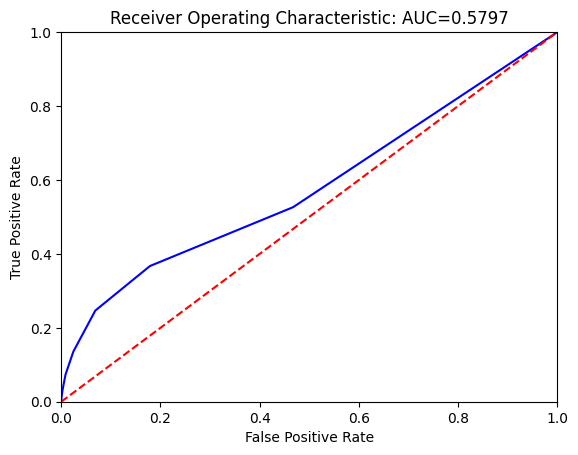

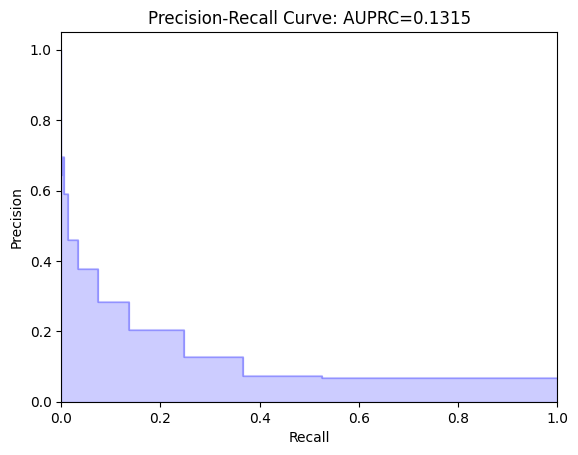

In [66]:
get_score_performance("score_NEWS2", random_seed=random_seed)

### 3.5.3 score_MEWS

score_MEWS
AUC: 0.5941752756987024
AUPRC: 0.1085170774499712
Sensitivity: 0.3898648648648649
Specificity: 0.7708600078976654
Score thresold: 2.0
2.5 97.5


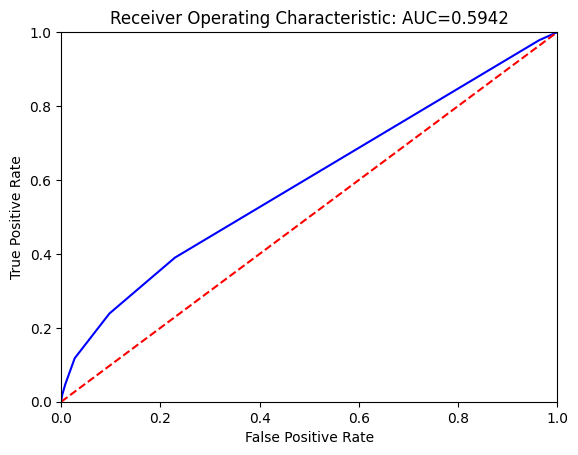

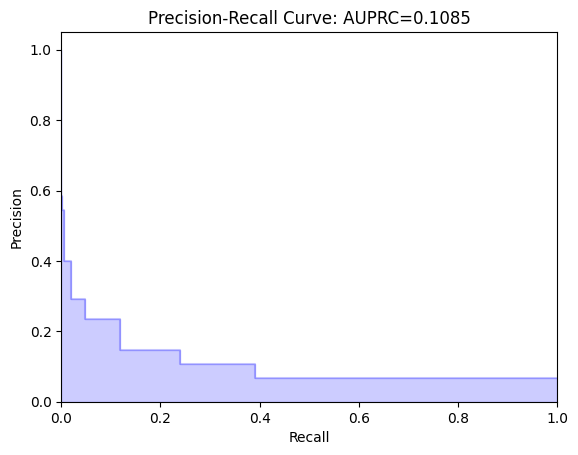

In [67]:
get_score_performance("score_MEWS", random_seed=random_seed)

# 4. Performance output
## 4.1 Consolidate Results

In [68]:
result_df = pd.DataFrame(result_list, columns = ['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 
                                                 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 
                                                 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 
                                                 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])

result_df.to_csv(os.path.join(path, 'result_critical_triage_jo_yt.csv'), index = False)

result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()

formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]

formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'

formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'

formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'

formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'

formatted_result_df[['Runtime']] = result_df[['runtime']]

formatted_result_df.to_csv(os.path.join(path, 'task2_jo_yt.csv'), index = False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,LR,0.481,0.886 (0.884-0.89),0.414 (0.402-0.426),0.822 (0.807-0.837),0.792 (0.777-0.806),6.779
1,LRv2,0.495,0.829 (0.826-0.832),0.31 (0.298-0.323),0.736 (0.72-0.752),0.766 (0.751-0.787),5.865
2,RF,0.090,0.943 (0.941-0.945),0.615 (0.601-0.626),0.885 (0.868-0.892),0.85 (0.849-0.866),71.017
3,RFv2,0.080,0.879 (0.877-0.882),0.396 (0.383-0.406),0.807 (0.802-0.816),0.805 (0.802-0.806),65.241
4,GB,0.080,0.945 (0.943-0.947),0.633 (0.618-0.64),0.878 (0.865-0.884),0.855 (0.848-0.866),113.293
5,GBv2,0.070,0.887 (0.884-0.89),0.438 (0.42-0.447),0.809 (0.797-0.825),0.805 (0.787-0.814),73.499
6,XGB,0.006,0.953 (0.951-0.954),0.673 (0.661-0.681),0.885 (0.875-0.892),0.868 (0.862-0.877),14.442
7,XGBv2,0.005,0.894 (0.891-0.897),0.451 (0.435-0.462),0.812 (0.807-0.833),0.816 (0.801-0.822),11.632
8,MLP,0.059,0.947 (0.945-0.948),0.636 (0.623-0.642),0.88 (0.87-0.901),0.853 (0.838-0.862),189.771
9,MLPv2,0.079,0.887 (0.883-0.89),0.42 (0.401-0.43),0.809 (0.801-0.823),0.805 (0.791-0.809),192.726


## 4.2 Compute Importance
### 4.2.1 First Prediction - using XGB

In [23]:
# best model: XGB
importances1 = xgb_clf.feature_importances_
 
importance_df1 = pd.DataFrame(importances1, columns = ['Importance'])
importance_df1 = pd.DataFrame(zip(variable2, importances1), columns=['Variable','Importance'])
 
pd.set_option('display.max_rows', 50) 
 
importance_df1.sort_values(by='Importance', axis=0,ascending=False).head(20)

,Variable,Importance
63,triage_MAP,0.257079
16,triage_pain,0.045110
17,triage_acuity,0.036018
12,triage_heartrate,0.021216
26,chiefcom_syncope,0.017150
25,chiefcom_fever_chills,0.016447
1,age,0.016242
14,triage_o2sat,0.014950
21,chiefcom_shortness_of_breath,0.014103
54,eci_WeightLoss,0.013411


### 4.2.2 Second Prediction (BEST Model) 

In [36]:
# best model: XGB
xgb = XGBClassifier(scale_pos_weight=ratio, objective='binary:logistic', n_jobs=-1, random_state=random_seed)
xgb.fit(X_train, y_train)
probs = xgb.predict_proba(X_test)

importances = xgb.feature_importances_
 
importance_df = pd.DataFrame(importances, columns = ['Importance'])
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
 
pd.set_option('display.max_rows', 50) 
 
importance_df.sort_values(by='Importance', axis=0,ascending=False).head(20)

,Variable,Importance
79,score_MEWS,0.102851
11,ed_los_hours,0.082587
17,triage_pain,0.050903
18,triage_acuity,0.037481
64,ed_heartrate_last,0.028769
73,insurance_Medicare,0.023852
16,triage_sbp,0.023322
72,insurance_Medicaid,0.021908
69,ed_pain_last,0.021800
10,n_icu_365d,0.020848


## 4.3 Visualise Importance

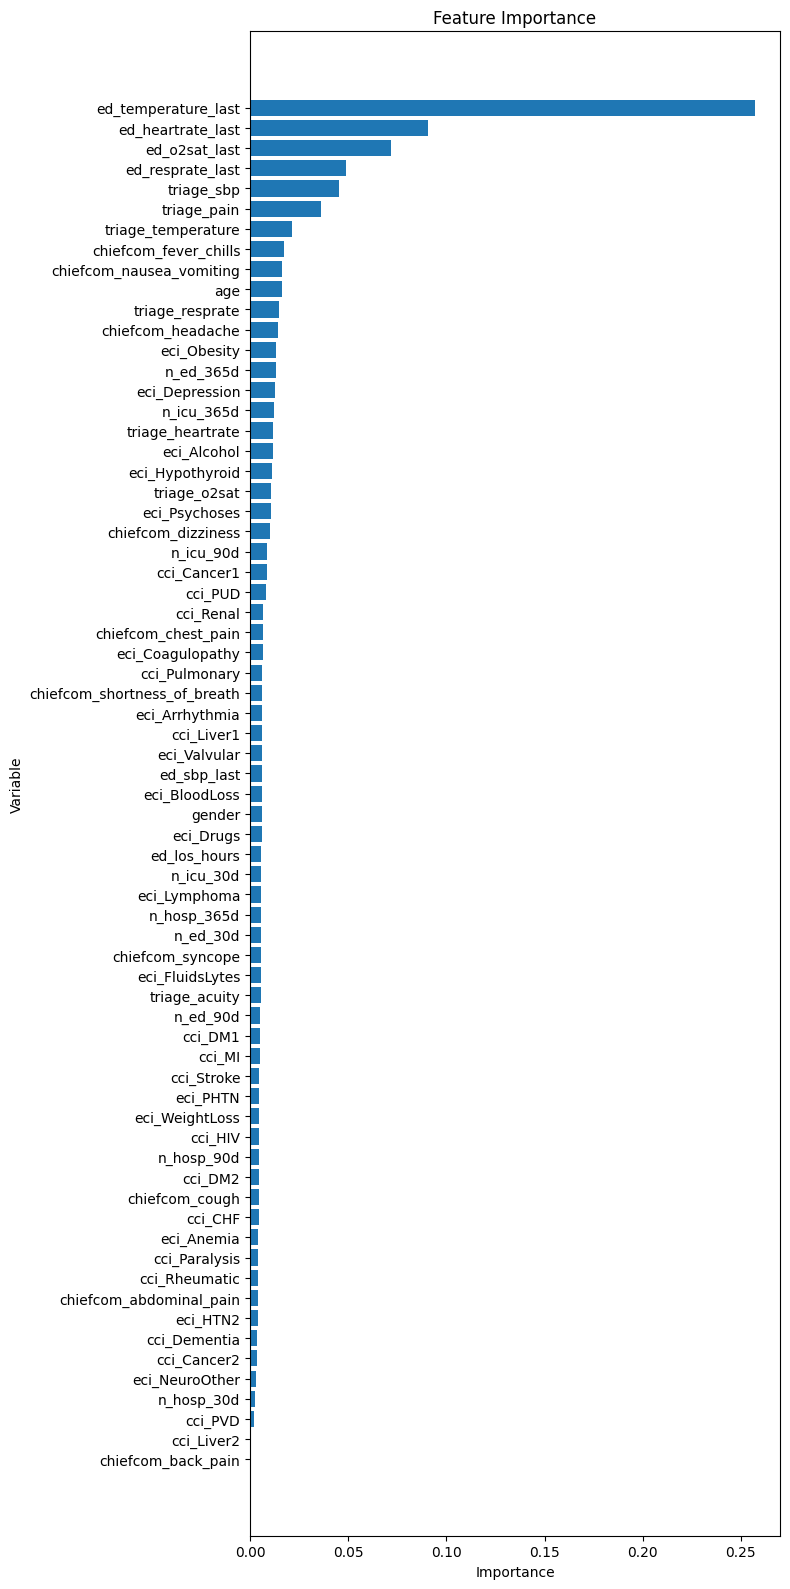

In [35]:
# first prediction
importance_df_sorted = importance_df.sort_values(by = 'Importance', 
                                                 ascending = True)
plt.figure(figsize=(8, 16))
plt.barh(importance_df_sorted['Variable'], importance_df_sorted['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

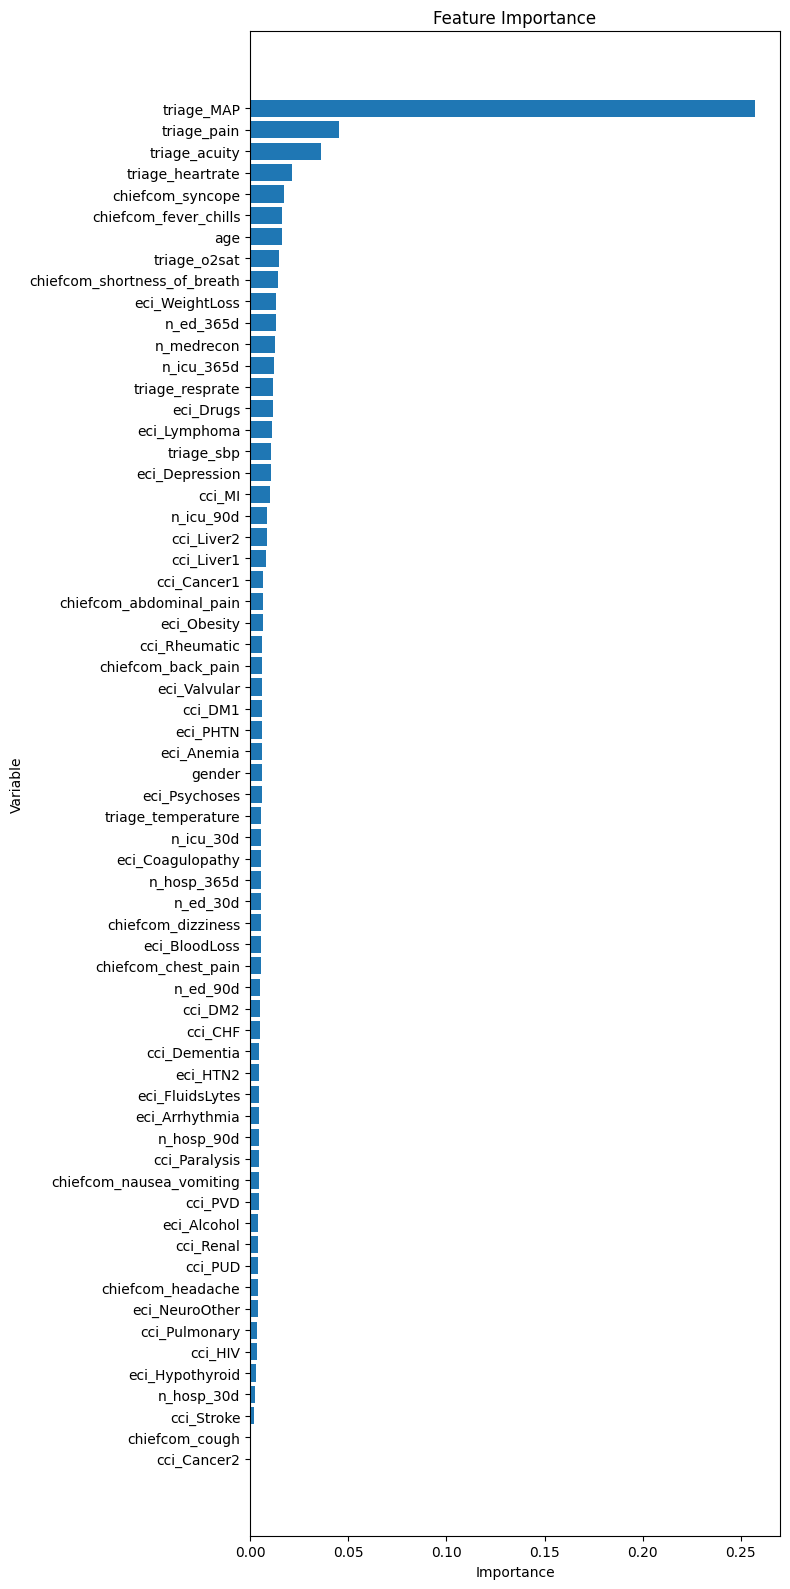

In [24]:
# second prediction
importance_df_sorted1 = importance_df1.sort_values(by = 'Importance', 
                                                 ascending = True)
plt.figure(figsize=(8, 16))
plt.barh(importance_df_sorted1['Variable'], importance_df_sorted1['Importance'])
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()